<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/BigDataProject/blob/main/IST718_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IST 718: Big Data Analysis Final Project


Project Process:

Data
1. Pull and Clean Data
2. High level Data Analysis (Time Series reporting)

Modeling
1. Run Hedgeye / Growth, Inflation, Policy (GIP) model (ARIMA)
2. Based on projected economic cycle outcome, develop model to determine what sector to invest in.  (Should this be a model to show buy or wait for any stocks)?  

In [2]:
# import packages for analysis and modeling
import pandas as pd  # data frame operations

import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import requests
from bs4 import BeautifulSoup
import datetime as dt


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Bring in treasury rates
url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll'

r = requests.get(url)
html = r.text

# gather the web page 
soup = BeautifulSoup(html)
table = soup.find('table', {"class": "t-chart"})
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

#create a dataframe of the treasury history
tre_hist = pd.DataFrame(data, columns=['Date', 'One_Mo', 'Two_Mo', 'Three_Mo', 'Six_Mo', 'One_Yr', 'Two_Yr', 'Three_Yr', 'Five_Yr', 'Seven_Yr', 'Ten_Yr', 'Twenty_Yr', 'Thirty_Yr'])

tre_hist.replace(to_replace='N/A', value=0, inplace=True)
tre_hist = tre_hist.astype({'One_Mo':'float64', 'Two_Mo':'float64', 'Three_Mo':'float64', 'Six_Mo':'float64', 'One_Yr':'float64', 'Two_Yr':'float64', 'Three_Yr':'float64', 'Five_Yr':'float64', 'Seven_Yr':'float64', 'Ten_Yr':'float64', 'Twenty_Yr':'float64', 'Thirty_Yr':'float64'})
tre_hist['Date'] = pd.to_datetime(tre_hist['Date'], format="%m/%d/%y")
tre_hist.head()

#SW comment: something looks off with Twenty Year rate

,Date,One_Mo,Two_Mo,Three_Mo,Six_Mo,One_Yr,Two_Yr,Three_Yr,Five_Yr,Seven_Yr,Ten_Yr,Twenty_Yr,Thirty_Yr
0,1990-01-02,0.0,0.0,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,0.0,8.00
1,1990-01-03,0.0,0.0,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,0.0,8.04
2,1990-01-04,0.0,0.0,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,0.0,8.04
3,1990-01-05,0.0,0.0,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,0.0,8.06
4,1990-01-08,0.0,0.0,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,0.0,8.09


In [4]:
#Bring in macro data


macro = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Macro%20Data.csv")
del macro['Unnamed: 7']
macro = macro.dropna()
macro.index = pd.to_datetime(macro['DATE'])
del macro['DATE']
macro.head()

#Need to determine how to handle NA data (replace or remove)

,CPIAUCSL,% Change (M/M),%Change (Q/Q),% Change (Y/Y),Nominal GDP,% Change Q/Q
DATE,,,,,,
1948-01-01,23.68,0.011468,0.033057,0.097509,265.742,0.022826
1948-02-01,23.67,-0.000422,0.026109,0.090590,265.742,0.022826
1948-03-01,23.50,-0.007208,0.003837,0.065958,265.742,0.022826
1948-04-01,23.82,0.013525,0.005895,0.079483,272.567,0.025359
1948-05-01,24.01,0.007945,0.014262,0.089703,272.567,0.025359


Text(0.5, 1.0, 'CPI and GDP Growth Change since 1949')

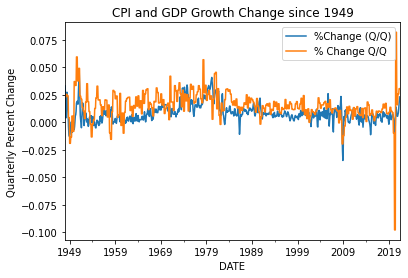

In [5]:
#need to update column names
macro["%Change (Q/Q)"].plot()
macro["% Change Q/Q"].plot()

plt.legend()
plt.ylabel("Quarterly Percent Change")
plt.title("CPI and GDP Growth Change since 1949")

In [6]:
import seaborn as sns
macro_2 = macro[["CPIAUCSL","Nominal GDP"]]
corr = macro_2.corr()
corr
#expand this to have more variables

,CPIAUCSL,Nominal GDP
CPIAUCSL,1.000000,0.978886
Nominal GDP,0.978886,1.000000


In [17]:
#what do we want to do with this data?  There are N/As on every row so we need to do more clean up.
index_data = pd.read_excel("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Index%20Sectors.xlsx", skiprows=2)
index_data = index_data[0:611]
index_data.head()

,Period Ending,S&P - 500 Index,S&P - 500 Index (GICS Communications Services),S&P - 500 Index (GICS Consumer Discretionary),S&P - 500 Index (GICS Consumer Staples),S&P - 500 Index (GICS Energy),S&P - 500 Index (GICS Financials),S&P - 500 Index (GICS Health Care),S&P - 500 Index (GICS Industrials),S&P - 500 Index (GICS Information Technology),S&P - 500 Index (GICS Materials),S&P - 500 Index (GICS Real Estate),S&P - 500 Index (GICS Utilities),U.S. Real Estate Index,U.S. Select Real Estate Securities Index,U.S. Select REIT Index,Dow Jones 30,Dow Jones - World Sustainability Index,Dow Jones - U.S. Total Stock Market Index,Dow Jones - U.S. Moderately Conservative Index\n,Dow Jones - U.S. Moderately Aggressive Index,Dow Jones - U.S. Moderate Index\n,Dow Jones - U.S. Conservative Index,Dow Jones - U.S. Completion Total Stock Market Index,Dow Jones - U.S. Aggressive Index,Dow Jones - Sustainability United States Index,Dow Jones - Sustainability North America Index,Dow Jones - Select Dividend Index,Dow Jones - Industrial Average Index (Price Return),Dow Jones - Industrial Average Index,Dow Jones - Global Select Real Estate Sec Corp Bd Index,Dow Jones - Global Moderately Conservative Index,Dow Jones - Global Moderately Aggressive Index,Dow Jones - Global Moderate Index,Dow Jones - Global ex-US Select Real Estate Securities Index,Dow Jones - Global Conservative Index,Dow Jones - Global Aggressive Index,Dow Jones - EPAC Select Dividend Index,Dow Jones - Commodity Index,NASDAQ - 100 Index,NASDAQ - Biotech Index,NASDAQ - Composite Index,NASDAQ - Developed ex North America Index,NASDAQ - Developed Markets Index,NASDAQ - Emerging Markets Index,NASDAQ - Global ex USA Index,NASDAQ - Global Index,NASDAQ - NASDAQ Over The Counter,NASDAQ - Ryan/NASDAQ US 1-30 Year Laddered Treasury Index,NASDAQ - US Dividend Achievers Select Index,NASDAQ - OTC Price Return,Russell - 1000 Index (GICS Communications Services Services),Russell - 1000 Index (GICS Consumer Discretionary),Russell - 1000 Index (GICS Consumer Staples),Russell - 1000 Index (GICS Energy),Russell - 1000 Index (GICS Financials),Russell - 1000 Index (GICS Health Care),Russell - 1000 Index (GICS Industrials),Russell - 1000 Index (GICS Information Technology),Russell - 1000 Index (GICS Real Estate),Russell - 1000 Index (GICS Utilities),Russell - 1000 Index (GICS Materials),Russell - 1000 Index (Price Return),Russell - 1000 Index
0,1970-07-31 00:00:00,7.687019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.401285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-08-31 00:00:00,4.778988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.149185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970-09-30 00:00:00,3.618744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.510084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1970-10-31 00:00:00,-0.831255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.666509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970-11-30 00:00:00,5.057057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.092574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
SP_index = index_data[["Period Ending","S&P - 500 Index"]]
SP_index.index = pd.to_datetime(SP_index['Period Ending'])
del SP_index['Period Ending']
SP_index.head()

,S&P - 500 Index
Period Ending,
1970-07-31,7.687019
1970-08-31,4.778988
1970-09-30,3.618744
1970-10-31,-0.831255
1970-11-30,5.057057


Text(0.5, 1.0, 'S&P - 500 Index')

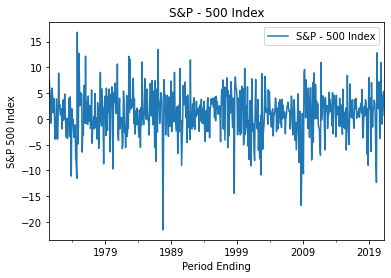

In [20]:
SP_index["S&P - 500 Index"].plot()

plt.legend()
plt.ylabel("S&P 500 Index")
plt.title("S&P - 500 Index")

#is this % change data?

In [16]:
#What information do we want to use here?
#Bring in pitch book data

pitchbook = pd.read_excel("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/PitchBook_All_Columns_2021_07_26_16_13_09.xlsx", skiprows=8)
pitchbook.head()

,Company ID,Companies,Latest Note,Latest Note – Author,Company Former Name,Company Also Known As,Company Legal Name,Competitors,PBId,Description,Primary Industry Sector,Primary Industry Group,Primary Industry Code,All Industries,Verticals,Keywords,Company Financing Status,Total Raised,Business Status,Ownership Status,Universe,Website,Employees,Employee History,Exchange,Ticker,Year Founded,Parent Company,Daily Updates,Weekly Updates,Revenue,Gross Profit,Net Income,Enterprise Value,EBITDA,EBIT,Market Cap,Net Debt,Revenue Growth %,Fiscal Period,...,Growth Rate % Change,Web Growth Rate,Web Growth Rate Percentile,Social Growth Rate,Social Growth Rate Percentile,SimilarWeb Growth Rate,SimilarWeb Growth Rate Percentile,Majestic Growth Rate,Majestic Growth Rate Percentile,Twitter Growth Rate,Twitter Growth Rate Percentile,Size Multiple,Size Multiple Percentile,Size Multiple Change,Size Multiple % Change,Web Size Multiple,Web Size Multiple Percentile,Social Size Multiple,Social Size Multiple Percentile,SimilarWeb Size Multiple,SimilarWeb Size Multiple Percentile,Majestic Size Multiple,Majestic Size Multiple Percentile,Twitter Size Multiple,Twitter Size Multiple Percentile,SimilarWeb Unique Visitors,SimilarWeb Unique Visitors Change,SimilarWeb Unique Visitors % Change,Majestic Referring Domains,Majestic Referring Domains Change,Majestic Referring Domains % Change,Twitter Followers,Twitter Followers Change,Twitter Followers % Change,Profile Data Source,Last Updated Date,Last Known Valuation,Last Known Valuation Date,Last Known Valuation Deal Type,PitchBook Link
0,60476-32,Accord Housing Association,NaN,NaN,NaN,Accord,Accord Housing Association Ltd,NaN,60476-32,Provider of housing and social care organizati...,Consumer Products and Services (B2C),Services (Non-Financial),Real Estate Services (B2C),"Elder and Disabled Care, Other Services (B2C N...",NaN,"real estate, real estate commercial property, ...",Private Equity-Backed,NaN,Generating Revenue,Acquired/Merged (Operating Subsidiary),Private Equity,www.accordgroup.org.uk,NaN,NaN,NaN,NaN,1965.0,Pension Insurance Corporation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FY 2020,...,-25.12,0.46,92.0,0.00,41.0,NaN,NaN,0.46,94.0,0.00,41.0,3.33,78.0,-0.03,-0.91,6.50,87.0,0.16,22.0,NaN,NaN,6.50,86.0,0.16,22.0,NaN,NaN,NaN,104.0,-1.0,-0.95,50.0,0.0,0.00,PitchBook Research,2021-06-19,138152.33,NaT,Buyout/LBO,View company online
1,106687-99,Verizon Wireless,NaN,NaN,NaN,"Verizon, Cellco Partnership","Verizon Wireless, Inc.","ZWireless, T-Mobile Netherlands, Cradlepoint, ...",106687-99,Operator of a wireless communications firm int...,Information Technology,Communications and Networking,Wireless Communications Equipment,"Electronics (B2C), Telecommunications Service ...","Mobile, TMT","broadband service, cellular telecommunication ...",Corporate Backed or Acquired,NaN,Generating Revenue,Acquired/Merged,M&A,www.verizonwireless.com,140000.0,"2012: 82000, 2020: 140000",NaN,NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FY 2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PitchBook Research,2021-06-19,288888.89,2014-02-21,Merger/Acquisition,View company online
2,168813-28,Al Hilal Bank,NaN,NaN,NaN,NaN,Al Hilal Bank PJSC,"Commercial Bank of Dubai, Capital One Financia...",168813-28,Operator of a commercial bank. The company pro...,Financial Services,Commercial Banks,National Banks,National Banks*,NaN,"bank deposits, banking services, debit card, f...",Corporate Backed or Acquired,825.00,Generating Revenue,Acquired/Merged (Operating Subsidiary),"M&A, Publicly Listed",www.alhilalbank.ae,NaN,NaN,NaN,NaN,2008.0,Abu Dhabi Commercial Bank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.55,1.13,96.0,-0.03,36.0,NaN,NaN,1.13,98.0,-0.03,36.0,65.13,99.0,0.49,0.77,28.44,97.0,141.24,98.0,NaN,NaN,28.44,96.0,141.24,98.0,NaN,NaN,NaN,453.0,6.0,1.34,44346.0,12.0,0.03,PitchBook Research,2020-01-31,115141.28,2019-